In [1]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/05 21:45:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
banks_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")

banks_rdd = banks_df.rdd

count = banks_rdd.filter(lambda row: "The" in row.respondent_name and "National" in row.respondent_name).count()

# Print the count
print(count)

106


In [4]:
#q1
banks_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")

banks_rdd = banks_df.rdd

count = banks_rdd.filter(lambda row: "The" in row.respondent_name and "National" in row.respondent_name).count()

count

106

In [5]:
#q2
banks_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")

count = banks_df.filter("respondent_name LIKE '%The%' AND respondent_name LIKE '%National%'").count()

count


106

In [6]:
loans_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/hdma-wi-2021.csv")

loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

tables = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

for table in tables:
    df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"hdfs://nn:9000/{table}.csv")
    df.createOrReplaceTempView(table)



24/04/05 21:46:40 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/05 21:46:40 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/04/05 21:46:45 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/04/05 21:46:45 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.25.0.6
24/04/05 21:46:47 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/04/05 21:46:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/04/05 21:47:17 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/04/05 21:47:18 WARN HiveConf

In [7]:
#q3
banks_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")

banks_df.write.saveAsTable("banks", mode="overwrite")

count_df = spark.sql("SELECT COUNT(*) AS count FROM banks WHERE respondent_name LIKE '%The%' AND respondent_name LIKE '%National%'")

count = count_df.collect()[0]['count']

count


106

In [8]:
#q4
tables_df = spark.sql("SHOW TABLES")
tables_list = tables_df.collect()
tables_dict = {row.tableName: row.isTemporary for row in tables_list}
tables_dict


{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [9]:
#q5
query = """
SELECT COUNT(*) AS num_applications
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
WHERE banks.respondent_name = 'First National Bank'
"""
num_applications = spark.sql(query).collect()[0]['num_applications']
num_applications


6

In [10]:
#q6
spark.sql(query).explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (12)
+- HashAggregate (11)
   +- Exchange (10)
      +- HashAggregate (9)
         +- Project (8)
            +- BroadcastHashJoin Inner BuildRight (7)
               :- Filter (2)
               :  +- Scan parquet spark_catalog.default.loans (1)
               +- BroadcastExchange (6)
                  +- Project (5)
                     +- Filter (4)
                        +- Scan parquet spark_catalog.default.banks (3)


(1) Scan parquet spark_catalog.default.loans
Output [1]: [lei#1075]
Batched: true
Bucketed: false (bucket column(s) not read)
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
PushedFilters: [IsNotNull(lei)]
ReadSchema: struct<lei:string>

(2) Filter
Input [1]: [lei#1075]
Condition : isnotnull(lei#1075)

(3) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#1047, lei_2020#1051]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(



1. The table that is sent to every executor via a BroadcastExchange operation is the banks table. This can be seen in the plan where there is a BroadcastExchange (6) followed by a BroadcastHashJoin (7) on the banks table.

2. Yes, the plan involves HashAggregate operations. There are two HashAggregate operations in the plan:

The first HashAggregate (9) is a partial aggregation that computes a partial count of the number of applications.
The second HashAggregate (11) is a final aggregation that computes the total count of the number of applications.


In [11]:
#q7
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

loans_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/hdma-wi-2021.csv")
banks_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")
counties_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/counties.csv")


wells_fargo_loans = loans_df.join(banks_df, loans_df.lei == banks_df.lei_2020).filter(col("respondent_name").contains("Wells Fargo"))

wells_fargo_loans_with_counties = wells_fargo_loans.join(counties_df, wells_fargo_loans.county_code == counties_df.STATE * 1000 + counties_df.COUNTY)

top_counties = wells_fargo_loans_with_counties.groupBy("NAME") \
                                              .agg({"loan_amount": "avg"}) \
                                              .withColumnRenamed("avg(loan_amount)", "avg_loan_amount") \
                                              .orderBy(col("avg_loan_amount").desc()) \
                                              .limit(10)

application_counts = wells_fargo_loans_with_counties.join(top_counties, "NAME") \
                                                    .groupBy("NAME") \
                                                    .count() \
                                                    .orderBy("NAME")

application_counts_dict = {row["NAME"]: row["count"] for row in application_counts.collect()}

application_counts_dict

{'Bayfield': 33,
 'Dane': 729,
 'Door': 174,
 'Florence': 8,
 'Forest': 7,
 'Oneida': 70,
 'Ozaukee': 389,
 'Sawyer': 38,
 'Vilas': 68,
 'Waukesha': 1832}

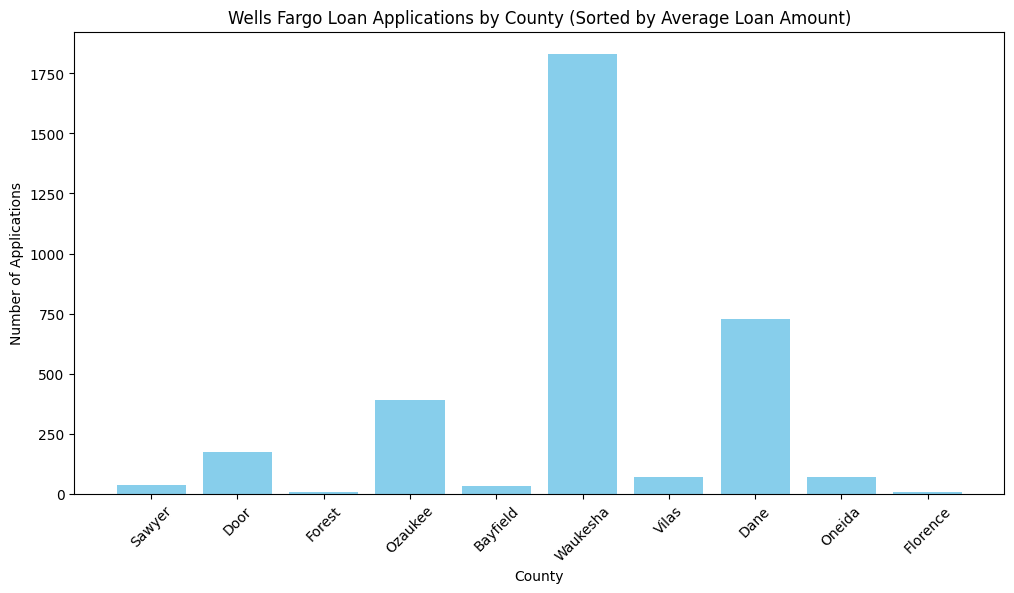

In [12]:
plot_data = application_counts.join(top_counties, application_counts.NAME == top_counties.NAME) \
                              .select(application_counts.NAME, "count", "avg_loan_amount") \
                              .orderBy("avg_loan_amount", ascending=False) \
                              .collect()

counties = [row["NAME"] for row in plot_data]
application_counts = [row["count"] for row in plot_data]
avg_loan_amounts = [row["avg_loan_amount"] for row in plot_data]

plt.figure(figsize=(12, 6))
plt.bar(counties, application_counts, color='skyblue')
plt.xlabel('County')
plt.ylabel('Number of Applications')
plt.title('Wells Fargo Loan Applications by County (Sorted by Average Loan Amount)')
plt.xticks(rotation=45)
plt.show()

In [13]:
#q8
from pyspark.sql.functions import mean

query1 = loans_df.groupBy("county_code").agg(mean("loan_amount").alias("avg_loan_amount"))
query1.explain()

query2 = loans_df.groupBy("lei").agg(mean("loan_amount").alias("avg_loan_amount"))
query2.explain()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#1203], functions=[avg(loan_amount#1220)])
   +- Exchange hashpartitioning(county_code#1203, 200), ENSURE_REQUIREMENTS, [plan_id=3309]
      +- HashAggregate(keys=[county_code#1203], functions=[partial_avg(loan_amount#1220)])
         +- FileScan csv [county_code#1203,loan_amount#1220] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/hdma-wi-2021.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,loan_amount:double>


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#1200], functions=[avg(loan_amount#1220)])
   +- Exchange hashpartitioning(lei#1200, 200), ENSURE_REQUIREMENTS, [plan_id=3322]
      +- HashAggregate(keys=[lei#1200], functions=[partial_avg(loan_amount#1220)])
         +- FileScan csv [lei#1200,loan_amount#1220] Batched: false, DataFilters: [], Format: CSV, Location: InMe

#q8
Network I/O is required in both queries between because of the shuffles that occur to redistribute the data for grouping.

The need for a shuffle, and, by extension, network I/O is determined by how the data is partitioned and what column you are grouping by. If the data is already partitioned with bucketing by a grouping column, a shuffle might be avoided. In this case, both queries require a shuffle because the data needs to be redistributed based on the grouping column.

In [14]:
#q9
from pyspark.sql.functions import col, when

df = spark.sql("SELECT loan_amount, income, interest_rate, action_taken as approval FROM loans").withColumn("approval", when(col("approval") == 1, 1.0).otherwise(0.0))

df = df.select(
    col("loan_amount").cast("double"),
    col("income").cast("double"),
    col("interest_rate").cast("double"),
    col("approval").cast("double")
)

df = df.fillna(0.0)

train, test = df.randomSplit([0.8, 0.2], seed=41)

train.filter(col("approval") == 1).count()

242868

In [15]:
#q10
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

vector_assembler = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")
train_features = vector_assembler.transform(train)
test_features = vector_assembler.transform(test)

rf_classifier = RandomForestClassifier(labelCol="approval", featuresCol="features", numTrees=10)
model = rf_classifier.fit(train_features)

predictions = model.transform(test_features)

answer = predictions.filter(col("approval") == col("prediction")).count() / test.count()

answer


0.8943554580972629